# torchopt as Meta-Optimizer

In this tutorial, we will show how to treat TorchOpt as a differentiable optimizor with traditional PyTorch optimization API. In addition, we also provide many other API for easy meta-learning algorithm implementations.

## 1. Basic API for differentiable optimizer

`MetaOptimizer` is the main class for our differnetiabl optimzier. Combined with the functional optimizer `torchopt.sgd` and `torchopt.adam` mentioned in the tutorial 1, we can define our high-level API `torchopt.MetaSGD` and `torchopt.MetaAdam`. We will discuss how this combination happens with `torchopt.chain` in Section 3. Let us consider the problem below.

Assume a tensor `x` is a meta parameter and `a` is a normal parameters (such as network parameters). We have inner loss li = `a0` * x^2 and we update `a` use the gradient dl/d`a0` = x^2 and `a1` = `a0` - dl/d`a0` = `a0` - x^2. Then we compute the outer loss lo = `a1` * x^2. So the gradient of outer loss to x would be:

dlo/dx

= da1/dx * x^2 + a1 * d(x^2)/dx

= d(a0 - x^2)/dx * x^2 + 2 * a1 * x

= -2 * x * x^2 + 2 * (a0 - x^2) * x

= -2 * x^3 + 2 * a0 * x - 2 * x^3

= -4 * x^3 + 2 * a0 * x

Given the analytical solution above. Let's try to verify it with TorchOpt. Define the net work first.

In [1]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1., requires_grad=True))
    
    def forward(self, x):
        return self.a * x ** 2

Then we declear network and x. Do not forget to set flag `requires_grad=True` for x.

In [2]:
net = Net()
x = torch.tensor(2., requires_grad=True)

Next we declear meta optimizer. The meta optimizer takes as input the network and use method `step` to update the network.

In [3]:
import torchopt

optim = torchopt.MetaSGD(net, lr=1.)
inner_loss = net(x)
optim.step(inner_loss)
outer_loss = net(x)
outer_loss.backward()
# x.grad should be:
# = -4 * x^3 + 2 * a0 * x 
# = -4 * 2^3 + 2 * 1 * 2 
# = -32 + 4 
# = -28
print(x.grad)

tensor(-28.)


### 1.1 Track the gradient of moment
Note that most modern optimizers involve moment term in the gradient update (basically only SGD with momentum = 0 does not involve). We provide an option for user to choose whether to also  track the meta-gradient through moment term. The default option is `moment_requires_grad=True`.
- When you do not track the meta-gradient through moment

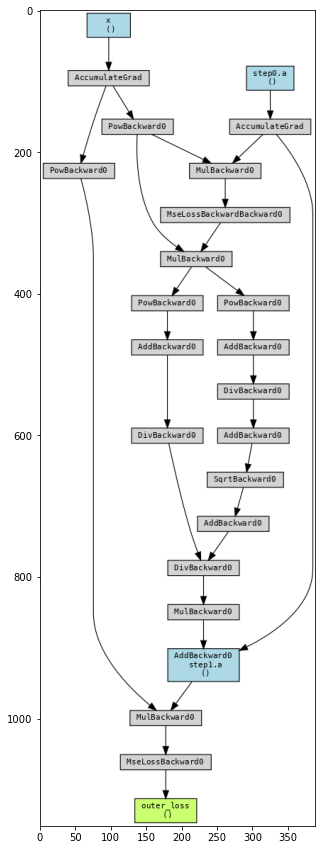

In [4]:
import matplotlib.pyplot as plt
from matplotlib import image as imgplt
import torch.nn.functional as F

net = Net()
x = torch.tensor(2., requires_grad=True)
y = torch.tensor(1.)

optim = torchopt.MetaAdam(net, lr=1., moment_requires_grad=False)
inner_loss = F.mse_loss(net(x), y)
net_state_0 = torchopt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step0.')
optim.step(inner_loss)
net_state_1 = torchopt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step1.')
outer_loss = F.mse_loss(net(x), y)
torchopt.visual.make_dot(outer_loss, params=[net_state_0, net_state_1,{'x': x, 'outer_loss': outer_loss}]).render("graph", format="png")
plt.figure(figsize=(15,15))
plt.imshow(imgplt.imread('graph.png'))

- When you track the meta-gradient through moment

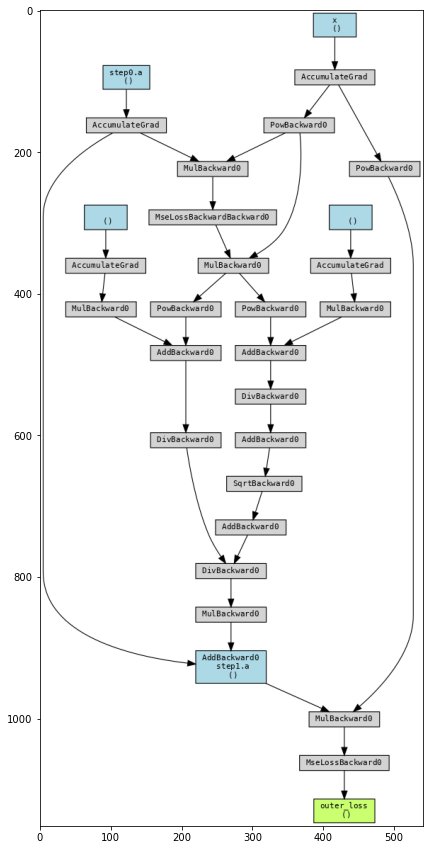

In [5]:
net = Net()
x = torch.tensor(2., requires_grad=True)
y = torch.tensor(1.)

optim = torchopt.MetaAdam(net, lr=1.)
inner_loss = F.mse_loss(net(x), y)
net_state_0 = torchopt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step0.')
optim.step(inner_loss)
net_state_1 = torchopt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step1.')

outer_loss = F.mse_loss(net(x), y)
torchopt.visual.make_dot(outer_loss, params=[net_state_0, net_state_1, {'x': x, 'outer_loss': outer_loss}]).render("graph", format="png")
plt.figure(figsize=(15,15))
plt.imshow(imgplt.imread('graph.png'))

We can see that the additional moment terms are added into the computational graph when we set `moment_requires_grad = True`.

## 2. Extract and Recover

### 2.1 Baisc API

We observe that how to reinitialize the inner-loop parameter in a new bi-level process vary in different Meta-Learning algorithms. For instance, in algorithm like MAML, every time a new task comes, we need to reset the parameters to the initial ones. In other cases such as Meta-gradient reinforcement learning, the inner-loop network parameter just inherit previous updated parameter to continue the new bi-level process.

We provide the `torchopt.extract_state_dict` and `torchopt.recover_state_dict` function to extract and restore the state of network and optimizer. By default, the extracted state dictionary is a reference (this design is for accumulating gradient of multi-task batch training, MAML for example). You can also set `copy=True` to extract the copy of state dictionary.

In [6]:
net = Net()
x = torch.tensor(2., requires_grad=True)
optim = torchopt.MetaAdam(net, lr=1.)
init_net_state = torchopt.extract_state_dict(net)
init_optim_state = torchopt.extract_state_dict(optim)

# get the copy of state dictionary
init_net_state_copy = torchopt.extract_state_dict(net, copy=True)
init_optim_state_copy = torchopt.extract_state_dict(optim, copy=True)

# Conduct 2 inner-loop optimization 
inner_loss = net(x)
optim.step(inner_loss)
inner_loss = net(x)
optim.step(inner_loss)
print(net.a)

# Recover and reconduct 2 inner-loop optimization 
torchopt.recover_state_dict(net, init_net_state)
torchopt.recover_state_dict(optim, init_optim_state)
inner_loss = net(x)
optim.step(inner_loss)
inner_loss = net(x)
optim.step(inner_loss)
outer_loss = net(x)
outer_loss.backward()
print(net.a)

# same result

tensor(-1., grad_fn=<AddBackward0>)
tensor(-1., grad_fn=<AddBackward0>)


### 2.2 Multi-task example with extract_state_dict, recover_state_dict

Let's move to another more complex setting. Meta Learning algorithms always fix network on several different tasks and accumulate outer loss of each task to the meta gradient.

Assume `x` is a meta parameter and `a` is a normal parameter. We firstly update `a` use inner loss li1 = `a0` * x^2 to `a1`. Then we use a1 to compute the outer loss lo1 = a1 * x^2 and backpropagate it. Then we use `a0` to compute the inner loss li2 = `a0` * x and update `a0` to `a2` (`a2` = `a0` - dli2/d`a0` = `a0` - x). Then we compute outer loss lo2 = `a2` * x and backpropagate it. So the accumulated meta gradient would be:

dlo1 / dx + dlo2 / dx

= (-4 * x^3 + 2 * a0 * x) + d(a2 * x)/dx

= (-4 * x^3 + 2 * a0 * x) + da2/dx * x + a2

= (-4 * x^3 + 2 * a0 * x) + d(a0 - x)/dx * x + a0 - x

= (-4 * x^3 + 2 * a0 * x) - 2 * x + a0

Let's define network and variables first.

In [7]:
class Net2Tasks(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1., requires_grad=True))
    
    def task1(self, x):
        return self.a * x ** 2
    
    def task2(self, x):
        return self.a * x


net = Net2Tasks()
x = torch.tensor(2., requires_grad=True)
optim = torchopt.MetaSGD(net, lr=1.)

Once we call `step` method of `MetaOptimizer`, the parameters of the network would be changed. We should use `torchopt.extract_state_dict` to extract state and use `torchopt.recover_state_dict` to recover the state. Note that if we use optimizers that have momentum buffers, we should also extract and recover them, vanilla SGD does not have momentum buffers so codes `init_optim_state = torchopt.extract_state_dict(optim)` and `torchopt.recover_state_dict(optim, init_optim_state)` have no effect.

In [8]:
init_net_state = torchopt.extract_state_dict(net)
init_optim_state = torchopt.extract_state_dict(optim)
# it's SGD so state_dict is empty
print(init_optim_state)

li1 = net.task1(x)
optim.step(li1)
lo1 = net.task1(x)
lo1.backward()
print(x.grad)

torchopt.recover_state_dict(net, init_net_state)
torchopt.recover_state_dict(optim, init_optim_state)
li2 = net.task2(x)
optim.step(li2)
lo2 = net.task2(x)
lo2.backward()

# extract_state_dict extract the reference so gradient accumulate
# x.grad should be (-4 * x^3 + 2 * a0 * x) - 2 * x + a0 = -28 - 2 * 2 + 1 = -31
print(x.grad)

((EmptyState(), EmptyState()),)
tensor(-28.)
tensor(-31.)


## 3. Gradient transformation in MetaOptimizer

We can also use some gradient normalization tricks in our `MetaOptimizer`. In fact `MetaOptimizer` decendents like `MetaSGD` are specializations of `MetaOptimizer`. Specifically, `MetaSGD(net, lr=1.)` is `MetaOptimizer(net, alias.sgd(lr=1., moment_requires_grad=True))`, where flag `moment_requires_grad=True` means the momentums are created with flag `requires_grad=True` so the momentums will also be the part of the computation graph.

In the desiging of TorchOpt, we treat these functions as derivations of `combine.chain`. So we can build our own chain like `combine.chain(clip.clip_grad_norm(max_norm=1.), sgd(lr=1., requires_grad=True))` to clip the gradient and update parameters using sgd.

dlo/dx

= da1/dx * x^2 + a1 * d(x^2)/dx

= d(a0 - x^2 / scale)/dx * x^2 + 2 * a1 * x

= -2 * x / scale * x^2 + 2 * (a0 - x^2 / scale) * x

= -2 * x^3 / scale + 2 * a0 * x - 2 * x^3 / scale

= -4 * x^3 / scale + 2 * a0 * x

In [9]:
net = Net()
x = torch.tensor(2., requires_grad=True)

impl = torchopt.combine.chain(torchopt.clip.clip_grad_norm(max_norm=2.), torchopt.sgd(lr=1., moment_requires_grad=True))
optim = torchopt.MetaOptimizer(net, impl)
li = net(x)
optim.step(li)
lo = net(x)
lo.backward()
# p.grad is -4 * x^3 / scale + 2 * a0 * x = -4 * 2^3 / scale + 2 * 1 * 2 = 4 - 32 / scale
# since max_norm is 2 and the gradient is x^2, so the scale should be x^2 / 2 = 2^2 / 2 = 2
# finally p.grad is 4 - 32 / 2 = -12
print(x.grad)

tensor(-12.0000)


## 4. Accelerated Optimizer

Users can use acclerated optimizer by seeting the `use_accelerated_op` as True. Currently we only support the Adam optimizer.

Check whether the accelerated_op is avariable:

In [8]:
torchopt.accelerated_op_available(torch.device("cpu"))

True

In [9]:
torchopt.accelerated_op_available(torch.device("cuda"))

True

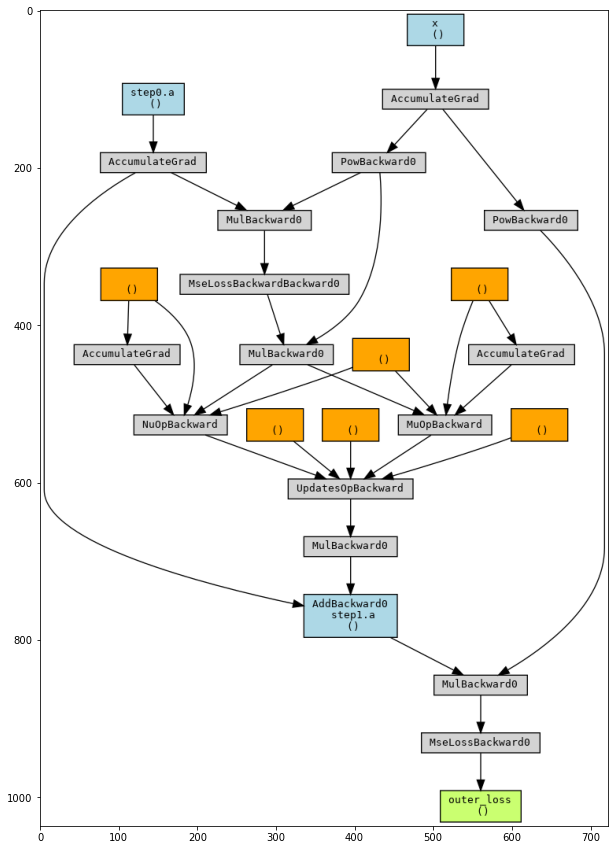

In [10]:
net = Net().cuda()
x = torch.tensor(2., requires_grad=True, device=torch.device("cuda"))
y = torch.tensor(1., device=torch.device("cuda"))

optim = torchopt.MetaAdam(net, lr=1., use_accelerated_op=True)

inner_loss = F.mse_loss(net(x), y)
net_state_0 = torchopt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step0.')
optim.step(inner_loss)
net_state_1 = torchopt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step1.')
outer_loss = F.mse_loss(net(x), y)
torchopt.visual.make_dot(outer_loss, params=[net_state_0, net_state_1,{'x': x, 'outer_loss': outer_loss}]).render("graph", format="png")
plt.figure(figsize=(15,15))
plt.imshow(imgplt.imread('graph.png'))